# Calculate AUROC

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm

def bootstrap_auc_ci(y, s, n_boot=1000, seed=42):
    """
    Pairs bootstrap 95% CI for AUROC within one subgroup.
    Resample (y, s) pairs with replacement.
    Skips resamples lacking both classes.
    """
    y = np.asarray(y).astype(int)
    s = np.asarray(s).astype(float)

    n = len(y)
    if n == 0 or len(np.unique(y)) < 2:
        return np.nan, np.nan, np.nan

    auc_hat = roc_auc_score(y, s)

    rng = np.random.default_rng(seed)
    aucs = []

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)  
        yb = y[idx]
        if len(np.unique(yb)) < 2:
            continue
        aucs.append(roc_auc_score(yb, s[idx]))

    if len(aucs) < max(30, 0.5 * n_boot):

        return float(auc_hat), np.nan, np.nan

    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return float(auc_hat), float(lo), float(hi)



data = pd.read_csv("SupplementaryTableS1.csv")

tools = [
    'PhyloP', 'Evo2', 'AlphaGenome_quantile', 'Rule_based',
    'GPN_MSA', 'PhyloGPN', 'Nucleotide_Transformer', 'DNABERT2',
    'ESM1b', 'ESM1v', 'ESM2', 'AlphaMissense', 'PrimateAI_3D'
]

subgroups = [
    'group: coding', 'group: missense', "group: missense + 3'UTR",
    'group: missense + intron (non-splice)', 'group: stop gain',
    'group: start loss', 'group: noncoding', 'group: stop loss',
    'group: synonymous', "group: 5'UTR", "group: 3'UTR",
    "group: 3'UTR + RNA gene", "group: splice",
    "group: intron (non-splice)", "group: RNA gene"
]

results = {group: {} for group in ['Overall'] + subgroups}
results_ci_low = {group: {} for group in ['Overall'] + subgroups}
results_ci_high = {group: {} for group in ['Overall'] + subgroups}


for idx, tool in tqdm(
    list(enumerate(tools)),
    desc="Overall (tools)",
    total=len(tools)
):
    if idx >= 8:
        results['Overall'][tool] = ""
        results_ci_low['Overall'][tool] = ""
        results_ci_high['Overall'][tool] = ""
        continue

    subset = data[data[tools[:6]].notna().all(axis=1)]
    if subset["ClinVar_label"].nunique() < 2:
        results['Overall'][tool] = ""
        results_ci_low['Overall'][tool] = ""
        results_ci_high['Overall'][tool] = ""
        continue

    auc_hat, lo, hi = bootstrap_auc_ci(
        subset["ClinVar_label"], subset[tool]
    )

    if tool not in ['PhyloP', 'Nucleotide_Transformer', 'Rule_based']:
        auc_hat = 1 - auc_hat
        lo, hi = 1 - hi, 1 - lo

    results['Overall'][tool] = round(auc_hat, 4)
    results_ci_low['Overall'][tool] = round(lo, 4)
    results_ci_high['Overall'][tool] = round(hi, 4)

results['Overall']['#Variants'] = len(subset)
results_ci_low['Overall']['#Variants'] = ""
results_ci_high['Overall']['#Variants'] = ""

n_positive_overall = subset["ClinVar_label"].sum() if len(subset) > 0 else 0
results['Overall']['p%'] = round(100 * n_positive_overall / len(subset), 2) if len(subset) > 0 else ""
results_ci_low['Overall']['p%'] = ""
results_ci_high['Overall']['p%'] = ""


for idx, subgroup in tqdm(
    list(enumerate(subgroups)),
    desc="Subgroups",
    total=len(subgroups)
):
    plm_flag = idx in [1, 2, 3]
    plm_noampai_flag = idx in [4]
    plm_noampai_flag_1 = idx in [5]

    if plm_flag:
        subset = data[(data[tools].notna().all(axis=1)) & (data[subgroup] == 1)]
        tool_list = tools.copy()
    elif plm_noampai_flag:
        subset = data[(data[tools[:12]].notna().all(axis=1)) & (data[subgroup] == 1)]
        tool_list = tools[:12].copy()
    elif plm_noampai_flag_1:
        subset = data[(data[tools[:11]].notna().all(axis=1)) & (data[subgroup] == 1)]
        tool_list = tools[:11].copy()
    else:
        subset = data[(data[tools[:8]].notna().all(axis=1)) & (data[subgroup] == 1)]
        tool_list = tools[:8].copy()

    results[subgroup]['#Variants'] = len(subset)
    results_ci_low[subgroup]['#Variants'] = ""
    results_ci_high[subgroup]['#Variants'] = ""

    total_variants = (data[subgroup] == 1).sum()
    n_positive = subset["ClinVar_label"].sum() if len(subset) > 0 else 0
    results[subgroup]['p%'] = round(100 * n_positive / total_variants, 2) if total_variants > 0 else ""
    results_ci_low[subgroup]['p%'] = ""
    results_ci_high[subgroup]['p%'] = ""

    for tool in tqdm(
        tools,
        desc=f"  Models in {subgroup}",
        leave=False
    ):
        if tool not in tool_list:
            results[subgroup][tool] = ""
            results_ci_low[subgroup][tool] = ""
            results_ci_high[subgroup][tool] = ""
            continue

        if len(subset) == 0 or subset["ClinVar_label"].nunique() < 2:
            results[subgroup][tool] = ""
            results_ci_low[subgroup][tool] = ""
            results_ci_high[subgroup][tool] = ""
            continue

        auc_hat, lo, hi = bootstrap_auc_ci(
            subset["ClinVar_label"], subset[tool]
        )

        if tool not in [
            'PhyloP', 'DNABERT2', 'Nucleotide_Transformer',
            'AlphaMissense', 'PrimateAI_3D',
            'AlphaGenome_quantile', 'Rule_based'
        ]:
            auc_hat = 1 - auc_hat
            lo, hi = 1 - hi, 1 - lo 

        results[subgroup][tool] = round(auc_hat, 4)
        results_ci_low[subgroup][tool] = round(lo, 4)
        results_ci_high[subgroup][tool] = round(hi, 4)


df_result = pd.DataFrame(results)
df_low = pd.DataFrame(results_ci_low)
df_high = pd.DataFrame(results_ci_high)

display(df_result)

df_result.to_csv("result.csv")
df_low.to_csv("result_ci_low.csv")
df_high.to_csv("result_ci_high.csv")

Subgroups: 100%|██████████| 15/15 [16:13<00:00, 64.87s/it]  


,Overall,group: coding,group: missense,group: missense + 3'UTR,group: missense + intron (non-splice),group: stop gain,group: start loss,group: noncoding,group: stop loss,group: synonymous,group: 5'UTR,group: 3'UTR,group: 3'UTR + RNA gene,group: splice,group: intron (non-splice),group: RNA gene
PhyloP,0.9079,0.8396,0.8562,0.8530,0.8680,0.7038,0.6748,0.9762,0.7964,0.8552,0.6959,0.8621,0.9323,0.7273,0.8518,0.882
Evo2,0.9693,0.9459,0.8363,0.8960,0.8352,0.6631,0.7106,0.9754,0.8255,0.8852,0.7671,0.7474,0.6354,0.6967,0.9035,0.4585
AlphaGenome_quantile,0.3097,0.5947,0.5596,0.5083,0.5834,0.3887,0.5228,0.9906,0.3622,0.919,0.5795,0.7891,0.513,0.5923,0.9598,0.8511
Rule_based,0.962,0.9228,0.5000,0.5000,0.5000,0.5,0.5,0.9442,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
GPN_MSA,0.96,0.9269,0.9065,0.8873,0.8960,0.7826,0.7689,0.9813,0.8876,0.8821,0.7277,0.908,0.9583,0.7749,0.8848,0.9384
PhyloGPN,0.9154,0.8666,0.7987,0.7291,0.6887,0.6767,0.5826,0.9506,0.695,0.8062,0.6012,0.7646,0.6771,0.7219,0.8457,0.4763
Nucleotide_Transformer,0.793,0.8067,0.5943,0.5456,0.6641,0.6182,0.569,0.8507,0.6087,0.7696,0.5674,0.5636,0.5573,0.6172,0.7502,0.3708
DNABERT2,0.5755,0.4342,0.4845,0.5456,0.4487,0.4831,0.3886,0.4334,0.5695,0.5525,0.4137,0.4994,0.6042,0.4542,0.4369,0.4227
ESM1b,,,0.9193,0.9059,0.7999,0.7884,0.6809,,,,,,,,,
ESM1v,,,0.8856,0.8697,0.7689,0.6562,0.6381,,,,,,,,,


# Plot figure 1

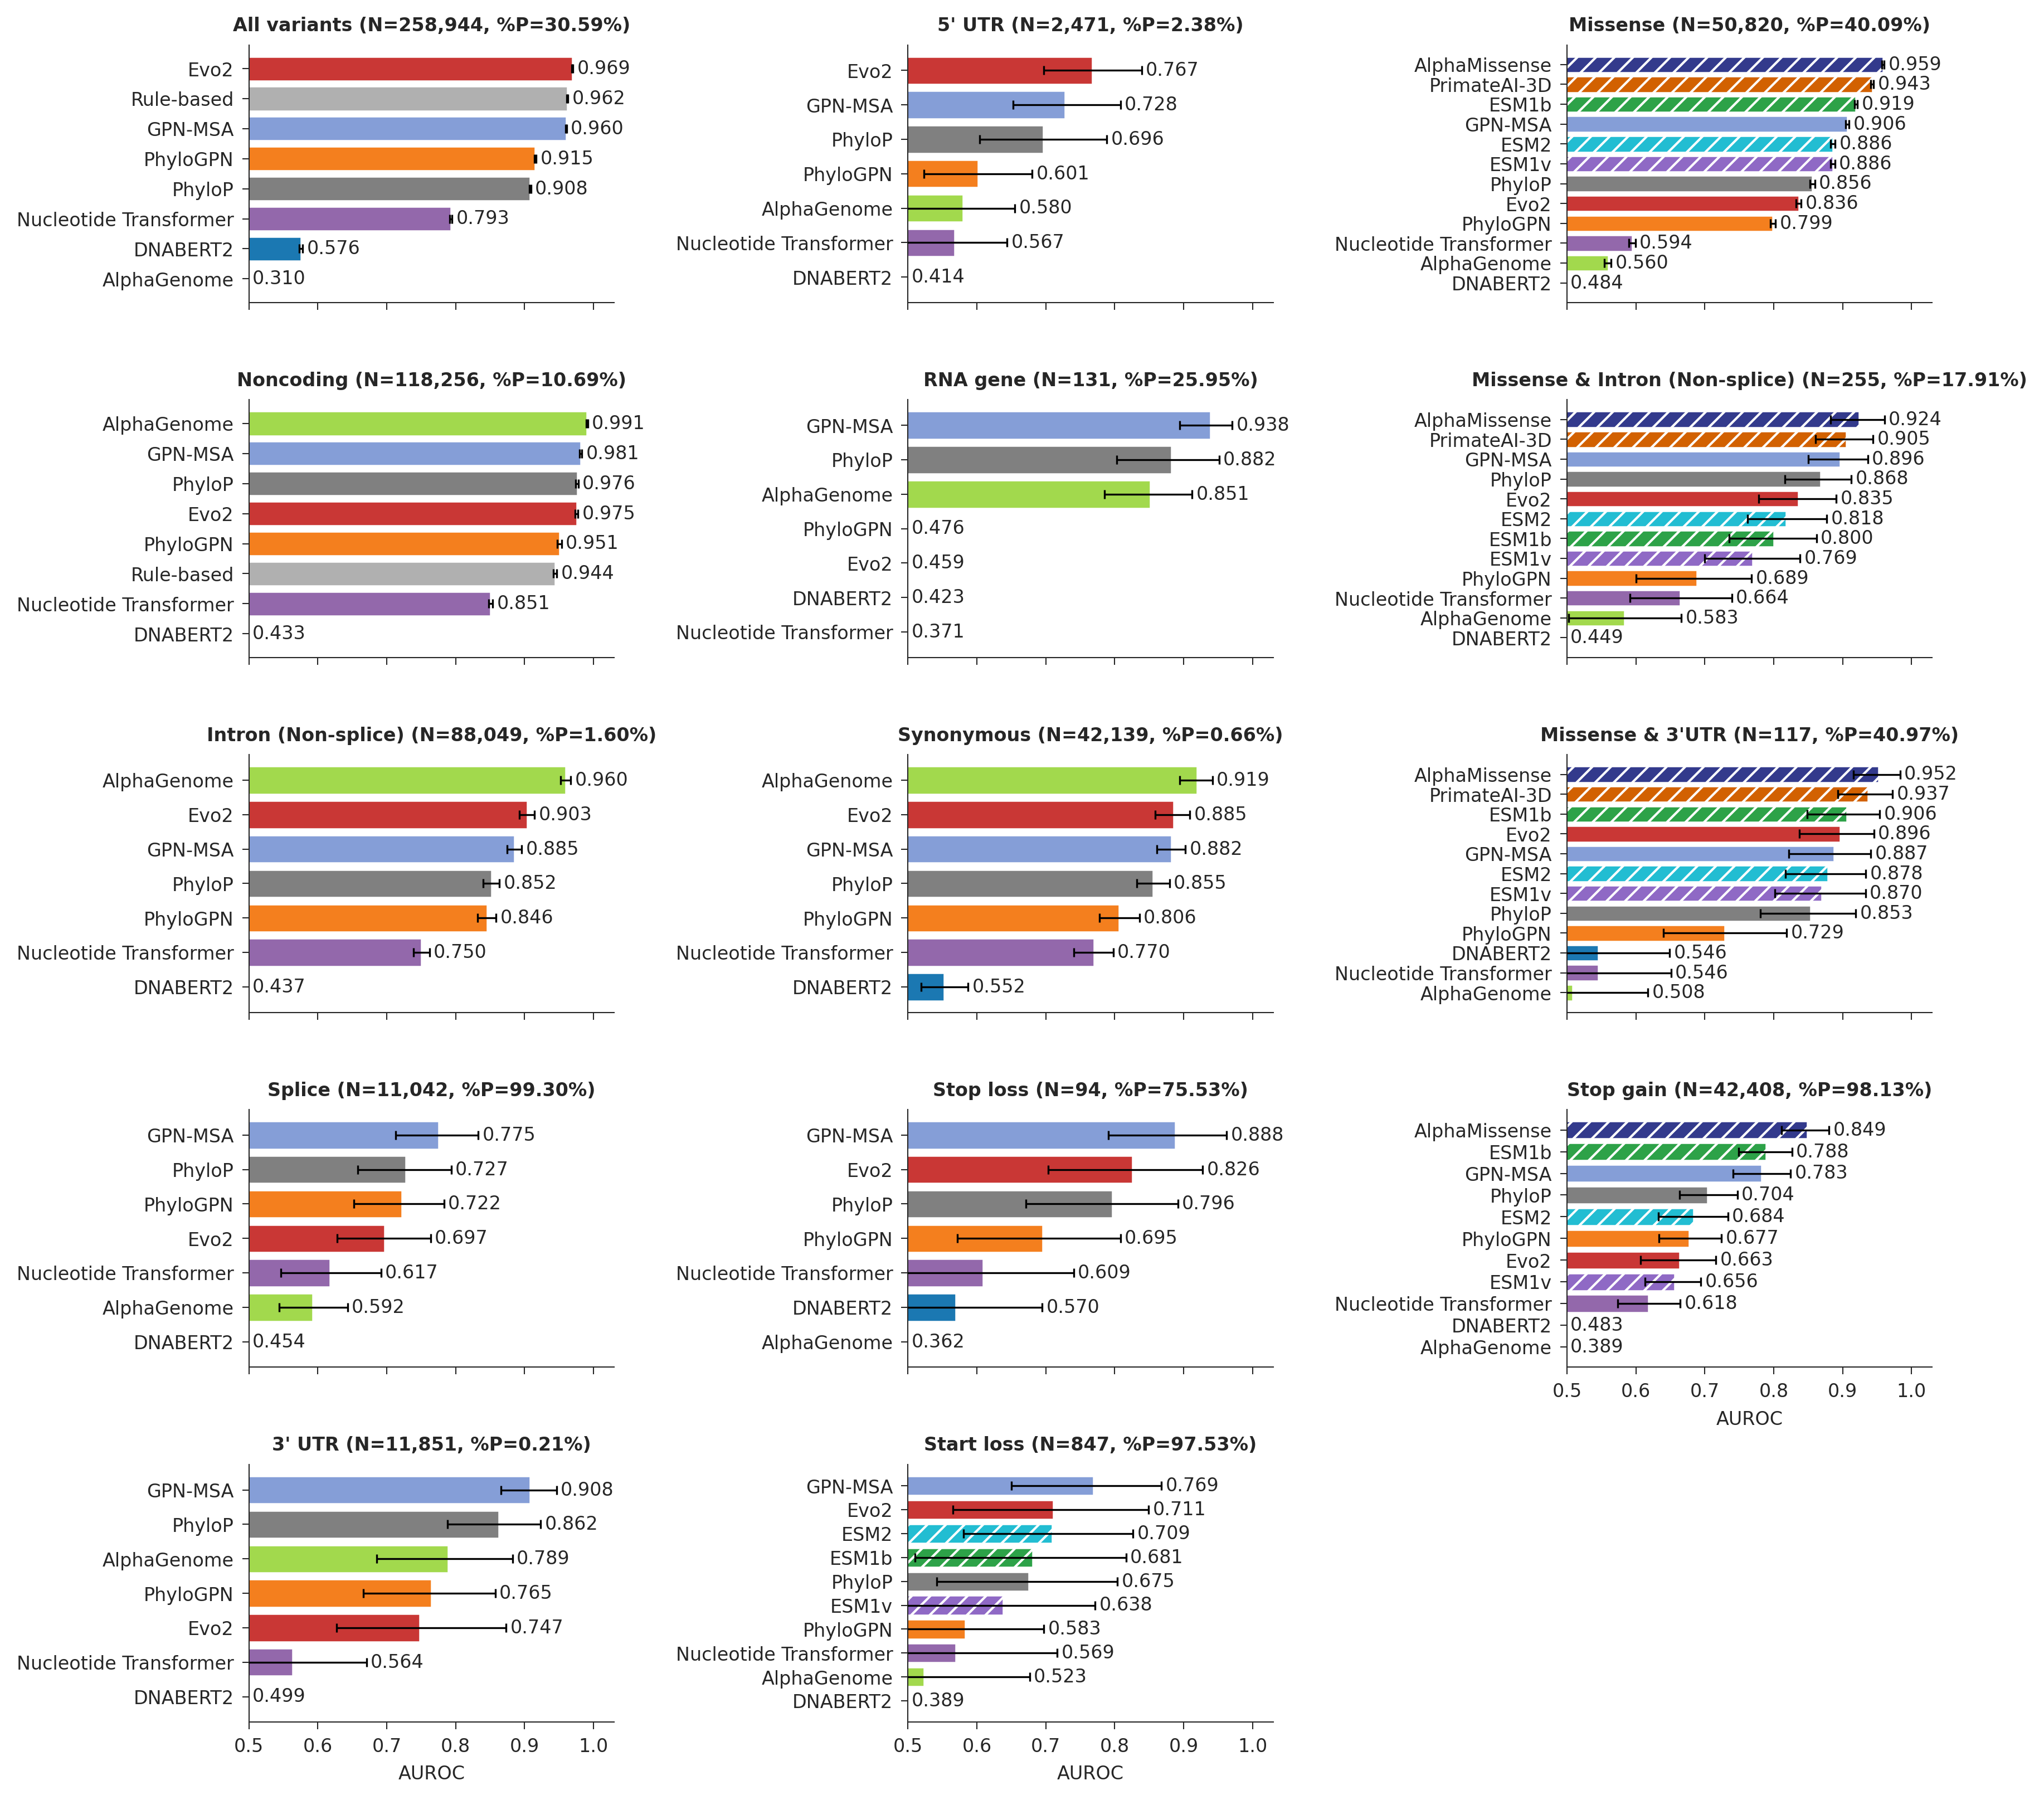

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
from collections import defaultdict
import numpy as np

FONT_SIZE = 8
FONT_NAME = 'DejaVu Sans' 

SAVE_BIG = True

df = pd.read_csv("result.csv")
df_low = pd.read_csv("result_ci_low.csv")
df_high = pd.read_csv("result_ci_high.csv")

rename_dict = {
    "Evo2": "Evo2", "DNABERT2": "DNABERT2", "Nucleotide_Transformer": "Nucleotide Transformer",
    "PhyloP": "PhyloP", "AlphaGenome_quantile": "AlphaGenome", "GPN_MSA": "GPN-MSA",
    "PhyloGPN": "PhyloGPN", "ESM1b": "ESM1b", "ESM1v": "ESM1v",
    "ESM2": "ESM2", "PrimateAI_3D": "PrimateAI-3D",
    "AlphaMissense": "AlphaMissense", "Rule_based": "Rule-based",
}

df = df.rename(columns=rename_dict)
df_low = df_low.rename(columns=rename_dict)
df_high = df_high.rename(columns=rename_dict)

df["Unnamed: 0"] = df["Unnamed: 0"].replace(rename_dict)
df_low["Unnamed: 0"] = df_low["Unnamed: 0"].replace(rename_dict)
df_high["Unnamed: 0"] = df_high["Unnamed: 0"].replace(rename_dict)

palette = {
    "Evo2": "#c93735", "DNABERT2": "#1b78b2", "Nucleotide Transformer": "#9368ab",
    "PhyloP": "#808080", "GPN-MSA": "#859ed7", "PhyloGPN": "#f47f1e",
    "AlphaGenome": "#a2d94d", "ESM1b": "#2da248", "ESM1v": "#8f69c5",
    "ESM2": "#22bdd2", "PrimateAI-3D": "#d26101", "AlphaMissense": "#333a8c",
    "Rule-based": "#b0b0b0",
}
dashed_models = ["ESM1b", "ESM1v", "ESM2", "AlphaMissense", "PrimateAI-3D"]

model_rows = df["Unnamed: 0"].tolist()[:-2]
df_models = df[df["Unnamed: 0"].isin(model_rows)].set_index("Unnamed: 0")
df_low_models = df_low[df_low["Unnamed: 0"].isin(model_rows)].set_index("Unnamed: 0")
df_high_models = df_high[df_high["Unnamed: 0"].isin(model_rows)].set_index("Unnamed: 0")

n_row = df[df["Unnamed: 0"] == "#Variants"].iloc[0]
p_row = df[df["Unnamed: 0"] == "p%"].iloc[0]

display_map = {
    "Overall": "All variants", "group: noncoding": "Noncoding",
    "group: intron (non-splice)": "Intron (Non-splice)",
    "group: splice": "Splice", "group: 5'UTR": "5' UTR",
    "group: 3'UTR": "3' UTR", "group: RNA gene": "RNA gene",
    "group: synonymous": "Synonymous", "group: start loss": "Start loss",
    "group: stop loss": "Stop loss", "group: missense": "Missense",
    "group: missense + intron (non-splice)": "Missense & Intron (Non-splice)",
    "group: missense + 3'UTR": "Missense & 3'UTR", "group: stop gain": "Stop gain",
}
ordered_display_names = [
    "All variants", "Noncoding", "Intron (Non-splice)", "Splice", "3' UTR", "5' UTR",
    "RNA gene", "Synonymous", "Stop loss","Start loss", 
    "Missense", "Missense & Intron (Non-splice)", "Missense & 3'UTR", "Stop gain"
]
reverse_display_map = {v: k for k, v in display_map.items()}

group_values = defaultdict(list)
for raw_k, disp_k in display_map.items():
    if raw_k in df_models.columns:
        for model in df_models.index:
            val = df_models.at[model, raw_k]
            if pd.notna(val) and val != "":
                group_values[raw_k].append((model, float(val)))

def style_axes(ax, show_xlabel=False, show_numbers=False):

    ax.set_xlim(0.5, 1.03)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

    xticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ax.set_xticks(xticks)

    ax.tick_params(axis='x', which='major', bottom=True, width=0.5, length=3.0)

    if show_numbers:
        ax.set_xticklabels([f"{t:.1f}" for t in xticks], fontsize=FONT_SIZE, fontname=FONT_NAME)
        ax.tick_params(axis='x', labelbottom=True)
    else:
        ax.tick_params(axis='x', labelbottom=False)

    if show_xlabel:
        ax.set_xlabel("AUROC", fontsize=FONT_SIZE, fontname=FONT_NAME)

    ax.tick_params(axis='y', which='major', left=True, labelleft=True, width=0.5, length=3.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.tick_params(labelsize=FONT_SIZE)
    for label in ax.get_yticklabels():
        label.set_fontname(FONT_NAME)

def draw_one_panel(ax, raw_key, display_name, show_xlabel=False, show_numbers=False):
    values = group_values[raw_key]
    if display_name not in ["All variants", "Noncoding"]:
        values = [(m, auc) for m, auc in values if m != "Rule-based"]

    rows = sorted(values, key=lambda x: x[1])

    x_left, x_right = ax.get_xlim()  
    x_pad = 0.006                    

    for model, auc in rows:
        color = palette.get(model, "#333333")
        hatch_style = '///' if model in dashed_models else None
        label = "PrimateAI-3D*" if (display_name == "Stop gain" and model == "PrimateAI-3D") else model

        # bar
        ax.barh(
            label, auc,
            color=color,
            hatch=hatch_style,
            edgecolor='white' if hatch_style else None,
            linewidth=0.6
        )

        # ---- get CI (if any) ----
        lo = hi = np.nan
        try:
            lo = df_low_models.at[model, raw_key]
            hi = df_high_models.at[model, raw_key]
        except Exception:
            lo, hi = np.nan, np.nan

        has_ci = (pd.notna(lo) and pd.notna(hi) and lo != "" and hi != "")
        if has_ci:
            lo = float(lo); hi = float(hi)
            lo = max(0.0, min(1.0, lo))
            hi = max(0.0, min(1.0, hi))
            has_ci = (hi >= lo)

        # ---- rule: keep original <0.5 behavior ----
        # If auc < 0.5: do not draw error bar, place number at x=0.5 region.
        if auc < 0.5:
            # number near left boundary
            ax.text(
                0.505, label, f"{auc:.3f}",
                va='center', ha='left',
                fontsize=FONT_SIZE, fontname=FONT_NAME
            )
            continue

        # ---- draw CI if valid and auc >= 0.5 ----
        if has_ci:
            ax.errorbar(
                x=auc, y=label,
                xerr=[[auc - lo], [hi - auc]],
                fmt='none',
                ecolor='black',
                elinewidth=0.8,
                capsize=2,
                capthick=0.8,
                zorder=10
            )
            x_anchor = max(auc, hi)   # place label after CI right end
        else:
            x_anchor = auc            # place label after auc

        # number label after right edge, but keep inside xlim
        x_text = min(x_anchor + x_pad, ax.get_xlim()[1] - 0.002)
        ax.text(
            x_text, label, f"{auc:.3f}",
            va='center', ha='left',
            fontsize=FONT_SIZE, fontname=FONT_NAME
        )

    n = int(float(n_row[raw_key]))
    p = float(p_row[raw_key])
    ax.set_title(
        f"{display_name} (N={n:,}, %P={p:.2f}%)",
        fontsize=FONT_SIZE, fontname=FONT_NAME, fontweight="bold"
    )
    style_axes(ax, show_xlabel=show_xlabel, show_numbers=show_numbers)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 11), dpi=300)
axes = axes.T.flatten()

for i, disp_name in enumerate(ordered_display_names):
    col = i // 5
    row = i % 5
    show_xlabel = (col == 0 and row == 4) or (col == 1 and row == 4) or (col == 2 and row == 3)
    show_numbers = show_xlabel
    draw_one_panel(
        axes[i],
        reverse_display_map[disp_name],
        disp_name,
        show_xlabel=show_xlabel,
        show_numbers=show_numbers
    )

axes[-1].axis('off')

plt.tight_layout()
if SAVE_BIG:
    plt.savefig("Figure1.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot figure 2

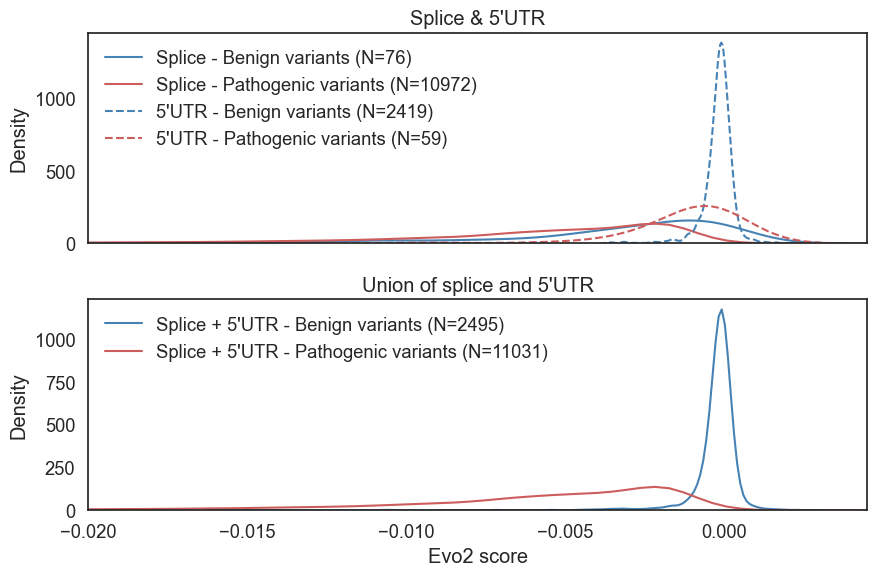

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
import numpy as np

sns.set(style="white", font_scale=1.2)

df = pd.read_csv("SupplementaryTableS1.csv")

def get_group(row):
    if row["group: 5'UTR"] == 1:
        return "5'UTR"
    elif row["group: splice"] == 1:
        return "Splice"
    else:
        return "Other"

df["group"] = df.apply(get_group, axis=1)
df = df[df["group"].isin(["5'UTR", "Splice"])]

df["label_str"] = df["ClinVar_label"].map({0: "Benign variants", 1: "Pathogenic variants"})

df_combined = df.copy()
df_combined["group_plot"] = df["group"]
df_add = df.copy()
df_add["group_plot"] = "Union of splice and 5'UTR"
df_all = pd.concat([df_combined, df_add], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

palette = {
    "Benign variants": "steelblue",
    "Pathogenic variants": "indianred"
}
linestyles = {
    "Splice": "-",
    "5'UTR": "--"
}

ax = axes[0]
for group in ["Splice", "5'UTR"]:
    for label in ["Benign variants", "Pathogenic variants"]:
        subset = df[(df["group"] == group) & (df["label_str"] == label)]
        if len(subset) > 1:
            sns.kdeplot(
                data=subset,
                x="Evo2",
                fill=False, 
                ax=ax,
                label=f"{group} - {label} (N={len(subset)})",
                color=palette[label],
                linestyle=linestyles[group],
                bw_adjust=0.8,
                common_norm=False
            )

ax.set_title("Splice & 5'UTR")
ax.set_ylabel("Density")
ax.set_xlabel("")
ax.legend(loc="upper left", frameon=False)

ax = axes[1]
for label in ["Benign variants", "Pathogenic variants"]:
    subset = df_all[(df_all["group_plot"] == "Union of splice and 5'UTR") & (df_all["label_str"] == label)]
    if len(subset) > 1:
        sns.kdeplot(
            data=subset,
            x="Evo2",
            fill=False, 
            ax=ax,
            label=f"Splice + 5'UTR - {label} (N={len(subset)})",
            color=palette[label],
            bw_adjust=0.8
        )

ax.set_title("Union of splice and 5'UTR")
ax.set_ylabel("Density")
ax.set_xlabel("Evo2 score")
ax.legend(loc="upper left", frameon=False)

for ax in axes:
    ax.set_xlim(-0.02, 0.0045)
plt.tight_layout()
plt.savefig("curve.svg", format="svg", bbox_inches="tight")
plt.show()

# Different Integration of AlphaGenome

In [ ]:
df = pd.read_csv("/gpfs/home/pl2948/VariantInterpretation/Data/ag_splice.csv")
df

In [ ]:
cols = [
    'SPLICE_SITES_quantile_abs', 'SPLICE_SITES_raw_abs',
    'SPLICE_SITE_USAGE_quantile_abs', 'SPLICE_SITE_USAGE_raw_abs',
    'SpliceJunction_quantile_abs', 'SpliceJunction_raw_abs',
    'composite_quantile_score', 'origin',
    'splice_head_composite_quantile_score', 'aggregate_splice'
]

na_counts = df[cols].isna().sum()
print(na_counts)

In [ ]:
cols = [
    'SPLICE_SITES_quantile_abs', 'SPLICE_SITES_raw_abs',
    'SPLICE_SITE_USAGE_quantile_abs', 'SPLICE_SITE_USAGE_raw_abs',
    'SpliceJunction_quantile_abs', 'SpliceJunction_raw_abs',
    'composite_quantile_score', 
    'splice_head_composite_quantile_score', 
    'aggregate_splice'
]

df_filtered = df.dropna(subset=cols)
df_filtered

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

auroc_results = {}
for col in cols:
    score = roc_auc_score(df_filtered["ClinVar_label"], df_filtered[col])
    auroc_results[col] = score

auroc_df = pd.DataFrame.from_dict(auroc_results, orient="index", columns=["AUC"])
auroc_df = auroc_df.sort_values("AUC", ascending=False)
display(auroc_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Style ===
FONT_SIZE = 8
# === Mapping ===
name_map = {
    'composite_quantile_score': 'All outputs (quantile)',
    'aggregate_splice': 'All splice outputs (raw)',
    'splice_head_composite_quantile_score': 'All splice outputs (quantile)',
    'SPLICE_SITE_USAGE_raw_abs': 'Splice site usage (raw)',
    'SPLICE_SITE_USAGE_quantile_abs': 'Splice site usage (quantile)',
    'SPLICE_SITES_raw_abs': 'Splice site (raw)',
    'SPLICE_SITES_quantile_abs': 'Splice site (quantile)',
    'SpliceJunction_raw_abs': 'Splice junction (raw)',
    'SpliceJunction_quantile_abs': 'Splice junction (quantile)'
}

# 颜色
palette = {
    'All outputs (quantile)': "#a2d94d", 
    'All splice outputs (raw)': "#1f77b4",
    'All splice outputs (quantile)': "#ff7f0e",
    'Splice site usage (raw)': "#2ca02c", 
    'Splice site usage (quantile)': "#d62728",
    'Splice site (raw)': "#9467bd", 
    'Splice site (quantile)': "#8c564b",
    'Splice junction (raw)': "#e377c2", 
    'Splice junction (quantile)': "#17becf"  
}

palette = {
    'All outputs (quantile)': "#a2d94d",

    'All splice outputs (raw)': "#a6cee3",
    'All splice outputs (quantile)': "#1f78b4",

    'Splice site usage (raw)': "#fdbf6f",
    'Splice site usage (quantile)': "#ff7f00",

    'Splice site (raw)': "#cab2d6",
    'Splice site (quantile)': "#6a3d9a",

    'Splice junction (raw)': "#fb9a99",
    'Splice junction (quantile)': "#e31a1c"
}

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)
for colname in list(name_map.keys())[::-1]:
    print(colname)
    label = name_map[colname]
    auc = auroc_df.loc[colname,"AUC"]
    color = palette.get(label, "#666666")

    ax.barh(
        y=label,
        width=auc,
        color=color,
        edgecolor='white',
        linewidth=0.6
    )
    ax.text(
        x=max(auc + 0.005, 0.505),
        y=label,
        s=f"{auc:.3f}",
        va='center', ha='left',
        fontsize=FONT_SIZE, fontname=FONT_NAME
    )

ax.set_xlabel("AUROC", fontsize=FONT_SIZE, fontname=FONT_NAME)
ax.set_xlim(0.5, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=FONT_SIZE)
ax.set_yticklabels(ax.get_yticklabels(), fontname=FONT_NAME)

plt.tight_layout()
# 保存为 SVG
plt.savefig("splice_v1.svg", format="svg", bbox_inches="tight")
plt.show()